
0: 64x64 with_mask 1.00, mask_weared_incorrect 0.00, without_mask 0.00, 2.4ms
Speed: 1.5ms preprocess, 2.4ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 with_mask 0.98, mask_weared_incorrect 0.01, without_mask 0.01, 2.1ms
Speed: 0.5ms preprocess, 2.1ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 with_mask 1.00, mask_weared_incorrect 0.00, without_mask 0.00, 2.2ms
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


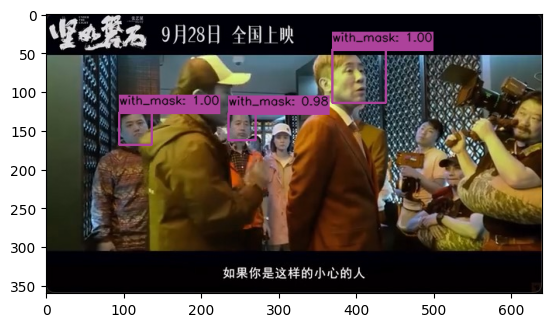


0: 64x64 mask_weared_incorrect 1.00, with_mask 0.00, without_mask 0.00, 8.9ms
Speed: 1.1ms preprocess, 8.9ms inference, 0.1ms postprocess per image at shape (1, 3, 64, 64)


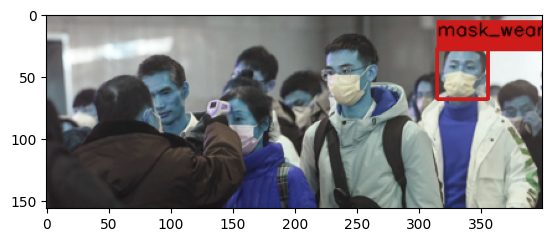


0: 64x64 with_mask 0.78, mask_weared_incorrect 0.22, without_mask 0.01, 6.6ms
Speed: 0.4ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 without_mask 0.91, with_mask 0.08, mask_weared_incorrect 0.01, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 with_mask 1.00, mask_weared_incorrect 0.00, without_mask 0.00, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 with_mask 1.00, mask_weared_incorrect 0.00, without_mask 0.00, 3.8ms
Speed: 1.3ms preprocess, 3.8ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


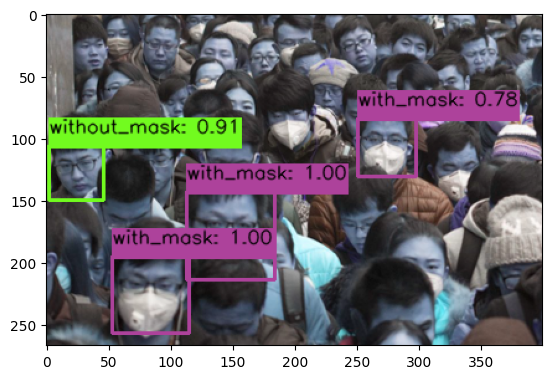


0: 64x64 mask_weared_incorrect 1.00, with_mask 0.00, without_mask 0.00, 3.2ms
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 mask_weared_incorrect 0.99, with_mask 0.01, without_mask 0.00, 3.6ms
Speed: 0.3ms preprocess, 3.6ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


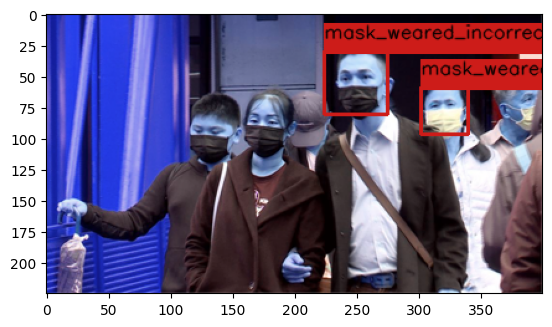

In [18]:
import onnxruntime as ort
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import PIL
import io

# Load a pretrained YOLOv8n model
model = YOLO("/Users/zhangzhichao/ML/models/mask-detection-cls_64.pt")

# results = model(
#     [
#         "../assets/images/1.jpg",
#         "../assets/images/maksssksksss1.png",
#         "../assets/images/maksssksksss110.png",
#         "../assets/images/maksssksksss116.png",
#     ]
# )
# # Show the results
# for r in results:
#     im_array = r.plot()  # plot a BGR numpy array of predictions
#     im = PIL.Image.fromarray(im_array[..., ::-1])  # RGB PIL image
#     im.show()  # show image

WIDHT = HEIGHT = 64
model_path = "/Users/zhangzhichao/ML/models/mask-detection-cls_64.onnx"
classes = {0: "mask_weared_incorrect", 1: "with_mask", 2: "without_mask"}

session = ort.InferenceSession(
    model_path, providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
)
# Get the model inputs
model_inputs = session.get_inputs()

# Store the shape of the input for later use
# input_shape = model_inputs[0].shape

face_cascade = cv2.CascadeClassifier()
face_cascade_name = "../assets/haarcascades/haarcascade_frontalface_alt.xml"
face_cascade.load(cv2.samples.findFile(face_cascade_name))

color_palette = np.random.uniform(0, 255, size=(len(classes), 3))


def draw_detections(img, box, score, class_id):
    x1, y1, w, h = box
    # Retrieve the color for the class ID
    color = color_palette[class_id]

    # Draw the bounding box on the image
    cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

    # Create the label text with class name and score
    label = f"{classes[class_id]}: {score:.2f}"

    # Calculate the dimensions of the label text
    (label_width, label_height), _ = cv2.getTextSize(
        label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1
    )

    # Calculate the position of the label text
    label_x = x1
    label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10

    # Draw a filled rectangle as the background for the label text
    cv2.rectangle(
        img,
        (label_x, label_y - label_height),
        (label_x + label_width, label_y + label_height),
        color,
        cv2.FILLED,
    )

    # Draw the label text on the image
    cv2.putText(
        img,
        label,
        (label_x, label_y),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 0),
        1,
        cv2.LINE_AA,
    )


def detect_mask(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.equalizeHist(frame_gray)
    # -- Detect faces
    faces = face_cascade.detectMultiScale(frame_gray, minSize=(30, 30))
    for x, y, w, h in faces:
        face = frame[y : y + h, x : x + w]

        # Resize the image to match the input shape
        face = cv2.resize(face, (WIDHT, HEIGHT))

        # Normalize the image data by dividing it by 255.0
        # image_data = np.array(face) / 255.0

        # Transpose the image to have the channel dimension as the first dimension
        # image_data = np.transpose(image_data, (2, 0, 1))  # Channel first

        # Expand the dimensions of the image data to match the expected input shape
        # image_data = np.expand_dims(image_data, axis=0).astype(np.float32)

        # onnx
        # outputs = session.run(None, {model_inputs[0].name: image_data})
        # classes_scores = np.transpose(np.squeeze(outputs[0]))
        # score = np.amax(classes_scores)
        # class_id = np.argmax(classes_scores)

        # yolo
        image_data = face
        # cv2.imwrite("./tmp.png", image_data)
        results = model.predict(image_data)
        result = results[0]
        # print(
        #     model.names[result.probs.top1],
        #     result.probs.top1,
        #     result.probs.top1conf.numpy(),
        # )
        class_id = result.probs.top1
        score = result.probs.top1conf.numpy()

        box = (x, y, w, h)
        draw_detections(frame, box, score, class_id)
    return frame


for img_path in [
    "../assets/images/1.jpg",
    "../assets/images/maksssksksss1.png",
    "../assets/images/maksssksksss110.png",
    "../assets/images/maksssksksss116.png",
]:
    img = cv2.imread(img_path)
    output_img = detect_mask(img)

    plt.imshow(output_img)
    plt.show()